<a href="https://colab.research.google.com/github/patrickjwolf/DS-Unit-2-Linear-Models/blob/master/module2-regression-2/Patrick_Wolf_assignment_regression_classification_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

# Regression 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [ ] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [ ] Engineer at least two new features. (See below for explanation & ideas.)
- [ ] Fit a linear regression model with at least two features.
- [ ] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Add your own stretch goal(s) !

**Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.**

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error

# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

In [0]:
import itertools
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
from sklearn.linear_model import LinearRegression

**Engineer at least two new features. (See below for explanation & ideas.)**


In [14]:
# added month and year

df['created'] = pd.to_datetime(df['created'])
df['month'] = df['created'].dt.month
df['year'] = df['created'].dt.year
df['pets_allowed'] = df['cats_allowed'] + df['dogs_allowed']

df.head()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,month,year,pets_allowed
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,2016,0
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,2016,2
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,2016,0
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,2016,0
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,2016,0


In [15]:
df.shape

(48817, 37)

In [16]:
train= df[(df['created'] > '2016-04-01 00:00:01')&(df['created'] < '2016-05-31 23:59:59')]
train = df.sample(n=100)
train.shape

(100, 37)

In [17]:
test= df[(df['created'] >= '2016-06-01 00:00:01')&(df['created'] < '2016-07-01 00:00:00')]
test.shape

(16973, 37)

In [18]:
df.describe()

,bathrooms,bedrooms,latitude,longitude,price,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,month,year,pets_allowed
count,48817.000000,48817.000000,48817.000000,48817.000000,48817.000000,48817.000000,48817.000000,48817.000000,48817.000000,48817.000000,48817.000000,48817.000000,48817.000000,48817.000000,48817.000000,48817.000000,48817.000000,48817.000000,48817.000000,48817.000000,48817.000000,48817.000000,48817.000000,48817.000000,48817.000000,48817.000000,48817.000000,48817.000000,48817.000000,48817.000000,48817.0,48817.000000
mean,1.201794,1.537149,40.750760,-73.972760,3579.585247,0.524838,0.478276,0.478276,0.447631,0.424852,0.415081,0.367085,0.052769,0.268452,0.185653,0.175902,0.132761,0.138394,0.102833,0.087203,0.060471,0.055206,0.051908,0.046193,0.043305,0.042711,0.039331,0.027224,0.026241,5.015486,2016.0,0.925907
std,0.470711,1.106087,0.038954,0.028883,1762.430772,0.499388,0.499533,0.499533,0.497255,0.494326,0.492741,0.482015,0.223573,0.443158,0.388830,0.380741,0.339320,0.345317,0.303744,0.282136,0.238359,0.228385,0.221844,0.209905,0.203544,0.202206,0.194382,0.162738,0.159852,0.824415,0.0,0.981025
min,0.000000,0.000000,40.575700,-74.087300,1375.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2016.0,0.000000
25%,1.000000,1.000000,40.728300,-73.991800,2500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2016.0,0.000000
50%,1.000000,1.000000,40.751700,-73.978000,3150.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2016.0,0.000000
75%,1.000000,2.000000,40.774000,-73.955000,4095.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2016.0,2.000000
max,10.000000,8.000000,40.989400,-73.700100,15500.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,2016.0,2.000000


**Fit a linear regression model with at least two features.**


In [0]:
model = LinearRegression()

In [0]:
def regression_3d(df, x, y, z, num=100, **kwargs):
    """
    Visualize linear regression in 3D: 2 features + 1 target
    
    df : Pandas DataFrame
    x : string, feature 1 column in df
    y : string, feature 2 column in df
    z : string, target column in df
    num : integer, number of quantiles for each feature
    """
    
    # Plot data
    fig = px.scatter_3d(df, x, y, z, **kwargs)
    
    # Fit Linear Regression
    features = [x, y]
    target = z
    model = LinearRegression()
    model.fit(df[features], df[target])    
    
    # Define grid of coordinates in the feature space
    xmin, xmax = df[x].min(), df[x].max()
    ymin, ymax = df[y].min(), df[y].max()
    xcoords = np.linspace(xmin, xmax, num)
    ycoords = np.linspace(ymin, ymax, num)
    coords = list(itertools.product(xcoords, ycoords))
    
    # Make predictions for the grid
    predictions = model.predict(coords)
    Z = predictions.reshape(num, num).T
    
    # Plot predictions as a 3D surface (plane)
    fig.add_trace(go.Surface(x=xcoords, y=ycoords, z=Z))
    
    return fig

In [21]:
regression_3d(
    train,
    x='pets_allowed', 
    y='new_construction',
    z='price',  
    text='interest_level',
    title='Rentals, April-June 2016')

**Get the model's coefficients and intercept.**


In [0]:
# Arrange y target vectors
target = 'price'
y_train = train[target]
y_test = test[target]

In [0]:
# 1. Import the appropriate estimator class from Scikit-Learn
from sklearn.linear_model import LinearRegression

In [0]:
# 2. Instantiate this class
model = LinearRegression()

In [25]:
# 3. Arrange X features matrices (already did y target vectors)
features = ['pets_allowed', 'new_construction']
X_train = train[features]
X_test = test[features]
print(f'Linear Regression, dependent on: {features}')

Linear Regression, dependent on: ['pets_allowed', 'new_construction']


In [26]:
# 4. Fit the model
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
mae = mean_absolute_error(y_train, y_pred)
print(f'Train Error: {mae:.2f} percentage points')

Train Error: 1444.34 percentage points


In [27]:
model.intercept_, model.coef_

(3979.9200688252777, array([-381.87157829, 1355.35314667]))

In [28]:
beta0 = model.intercept_
beta1, beta2 = model.coef_
print(f'y = {beta0} + {beta1}x1 + {beta2}x2')

y = 3979.9200688252777 + -381.8715782887533x1 + 1355.3531466708375x2


**Get regression metrics RMSE, MAE, and  R2 , for both the train and test data.**


In [0]:
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def squared_errors(df, feature, target, m, b):
    """
    Visualize linear regression, with squared errors,
    in 2D: 1 feature + 1 target.
    
    Use the m & b parameters to "fit the model" manually.
    
    df : Pandas DataFrame
    feature : string, feature column in df
    target : string, target column in df
    m : numeric, slope for linear equation
    b : numeric, intercept for linear requation
    """
   # Plot data
    fig = plt.figure(figsize=(7,7))
    ax = plt.axes()
    df.plot.scatter(feature, target, ax=ax)
    
    # Make predictions
    x = df[feature]
    y = df[target]
    y_pred = m*x + b
    
    # Plot predictions
    ax.plot(x, y_pred)
    
    # Plot squared errors
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    scale = (xmax-xmin)/(ymax-ymin)
    for x, y1, y2 in zip(x, y, y_pred):
        bottom_left = (x, min(y1, y2))
        height = abs(y1 - y2)
        width = height * scale
        ax.add_patch(Rectangle(xy=bottom_left, width=width, height=height, alpha=0.1))
    
    # Print regression metrics
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print('Mean Squared Error:', mse)
    print('Root Mean Squared Error:', rmse)
    print('Mean Absolute Error:', mae)
    print('R^2:', r2)


Mean Squared Error: 4890018.8036
Root Mean Squared Error: 2211.3386903864366
Mean Absolute Error: 1474.9288000000004
R^2: 0.0


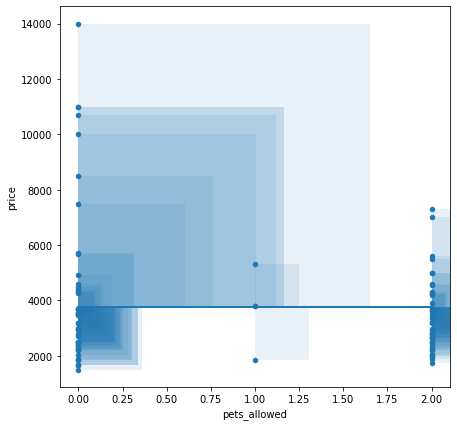

In [36]:
#Train regression metrics RMSE, MAE, and R2

feature = 'pets_allowed'
squared_errors(train, feature, target, m=0, b=y_train.mean())

Mean Squared Error: 3108021.267852562
Root Mean Squared Error: 1762.9581015590138
Mean Absolute Error: 1200.8695333832386
R^2: 0.0


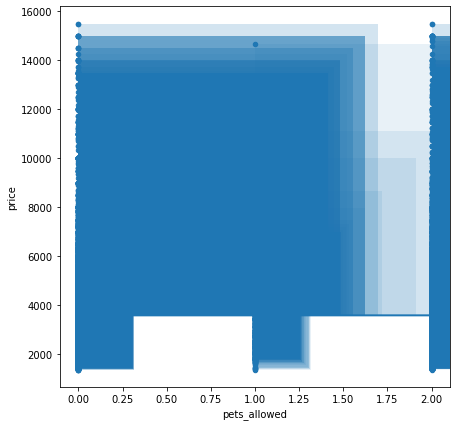

In [40]:
#Test regression metrics RMSE, MAE, and R2

feature = 'pets_allowed'
squared_errors(test, feature, target, m=0, b=y_test.mean())

**What's the best test MAE you can get? Share your score and features used with your cohort on Slack!**

In [41]:
# X is a matrix. Add column of constants for fitting the intercept.
def add_constant(X):
    constant = np.ones(shape=(len(X),1))
    return np.hstack((constant, X))
X = add_constant(train[features].values)
print('X')
print(X)

# y is a column vector
y = train[target].values[:, np.newaxis]
print('y')
print(y)

# Least squares solution in code
X_transpose = X.T
X_transpose_X = X_transpose @ X
X_transpose_X_inverse = np.linalg.inv(X_transpose_X)
X_transpose_y = X_transpose @ y
beta_hat = X_transpose_X_inverse @ X_transpose_y

print('Beta Hat')
print(beta_hat)

X
[[1. 0. 1.]
 [1. 2. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 2. 0.]
 [1. 2. 1.]
 [1. 2. 0.]
 [1. 0. 0.]
 [1. 2. 0.]
 [1. 2. 1.]
 [1. 0. 0.]
 [1. 1. 0.]
 [1. 2. 0.]
 [1. 2. 0.]
 [1. 2. 0.]
 [1. 2. 0.]
 [1. 2. 0.]
 [1. 2. 0.]
 [1. 0. 0.]
 [1. 2. 0.]
 [1. 2. 1.]
 [1. 2. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 2. 0.]
 [1. 2. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 2. 0.]
 [1. 2. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 2. 0.]
 [1. 0. 0.]
 [1. 0. 1.]
 [1. 2. 1.]
 [1. 2. 0.]
 [1. 0. 0.]
 [1. 2. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 2. 0.]
 [1. 2. 0.]
 [1. 2. 0.]
 [1. 0. 0.]
 [1. 2. 0.]
 [1. 2. 0.]
 [1. 0. 0.]
 [1. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 2. 0.]
 [1. 2. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 2. 0.]
 [1. 0. 0.]
 [1. 2. 0.]
 [1. 0. 0.]
 [1. 2. 0.]
 [1. 2. 0.]
 [1. 0. 0.]
 [1. 2. 0.]
 [1. 2. 1.]
 [